# Analyse exploratoire du dataset Wine : Visualisations avec Matplotlib et Seaborn.

## 1-Importation des Librairies et chargement du jeu de données

In [1]:
#Importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Chargement du dataset
data = pd.read_csv("/home/lea/dashboard/wine/wine.data")

## 2-Ajustement des noms de colonnes

In [7]:
data.columns = [
    "Class",
    "Alcohol",
    "Malic acid",
    "Ash",
    "Alcalinity of ash",
    "Magnesium",
    "Total phenols",
    "Flavanoids",
    "Nonflavanoid phenols",
    "Proanthocyanins",
    "Color intensity",
    "Hue",
    "OD280/OD315 of diluted wines",
    "Proline"
]


In [8]:
print(data.head())

   Class  Alcohol  Malic acid   Ash  Alcalinity of ash  Magnesium  \
0      1    13.20        1.78  2.14               11.2        100   
1      1    13.16        2.36  2.67               18.6        101   
2      1    14.37        1.95  2.50               16.8        113   
3      1    13.24        2.59  2.87               21.0        118   
4      1    14.20        1.76  2.45               15.2        112   

   Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  \
0           2.65        2.76                  0.26             1.28   
1           2.80        3.24                  0.30             2.81   
2           3.85        3.49                  0.24             2.18   
3           2.80        2.69                  0.39             1.82   
4           3.27        3.39                  0.34             1.97   

   Color intensity   Hue  OD280/OD315 of diluted wines  Proline  
0             4.38  1.05                          3.40     1050  
1             5.68  1.03  

## 3-Différents Graphiques

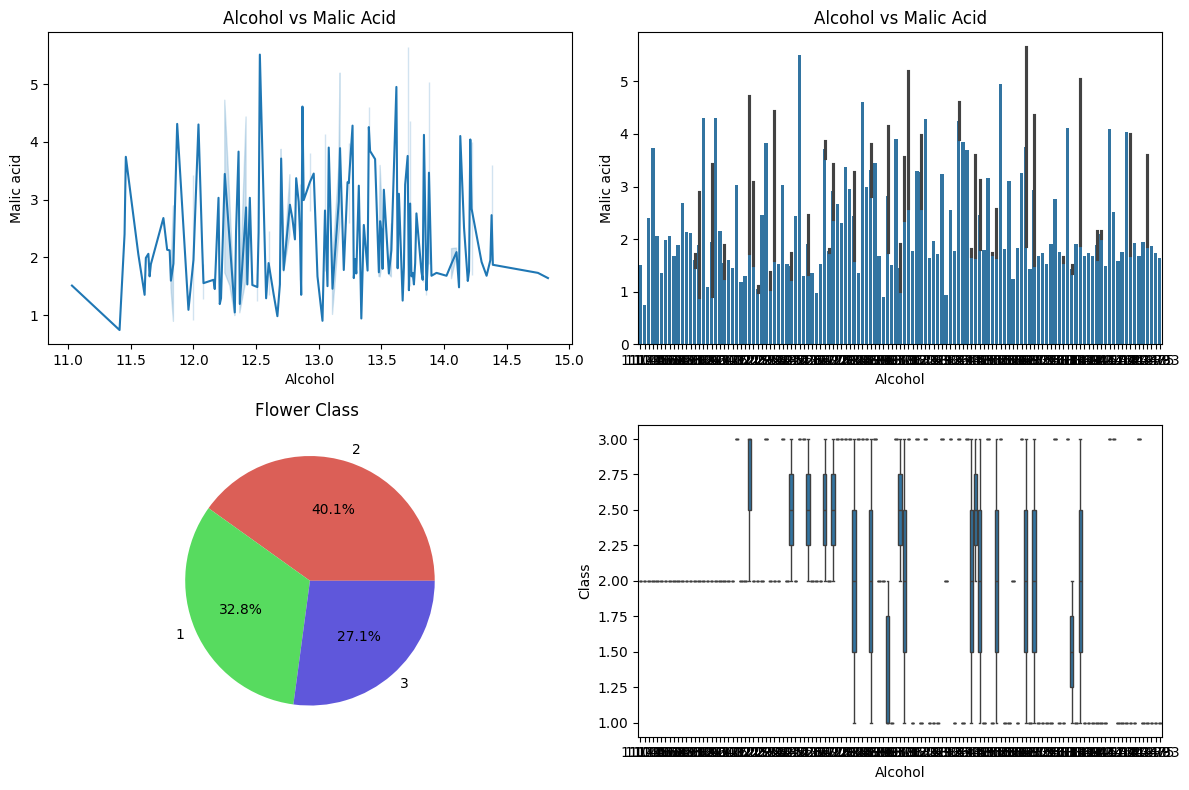

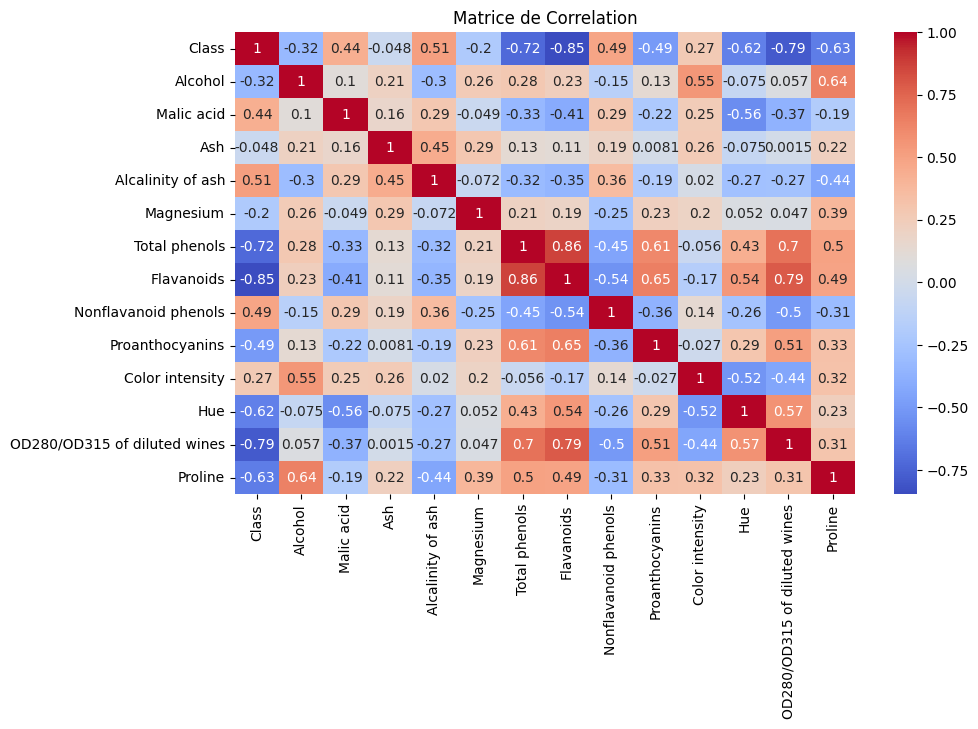

In [44]:
# Create a dashboard layout
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# Line chart of sepal length vs sepal width
sns.lineplot(x="Alcohol", y="Malic acid", data=data, ax=axes[0, 0])
axes[0, 0].set_title("Alcohol vs Malic Acid")
# Bar chart of petal length vs petal width
sns.barplot(x="Alcohol", y="Malic acid", data=data, ax=axes[0, 1])
axes[0, 1].set_title("Alcohol vs Malic Acid")
# Pie chart of flower species distribution
species_counts = data["Class"].value_counts()
labels = species_counts.index.to_list()
colors = sns.color_palette("hls", len(labels))
axes[1, 0].pie(species_counts, labels=labels, colors=colors, autopct="%.1f%%")
axes[1, 0].set_title("Flower Class ")
# Diagramme en boîte multiple
sns.boxplot(data=data, x='Alcohol', y='Class')
# Improve layout and show the dashboard
plt.tight_layout()
plt.show()
#matrice de corrélation
plt.figure(figsize=(10, 6))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm").set_title("Matrice de Correlation")
plt.show()

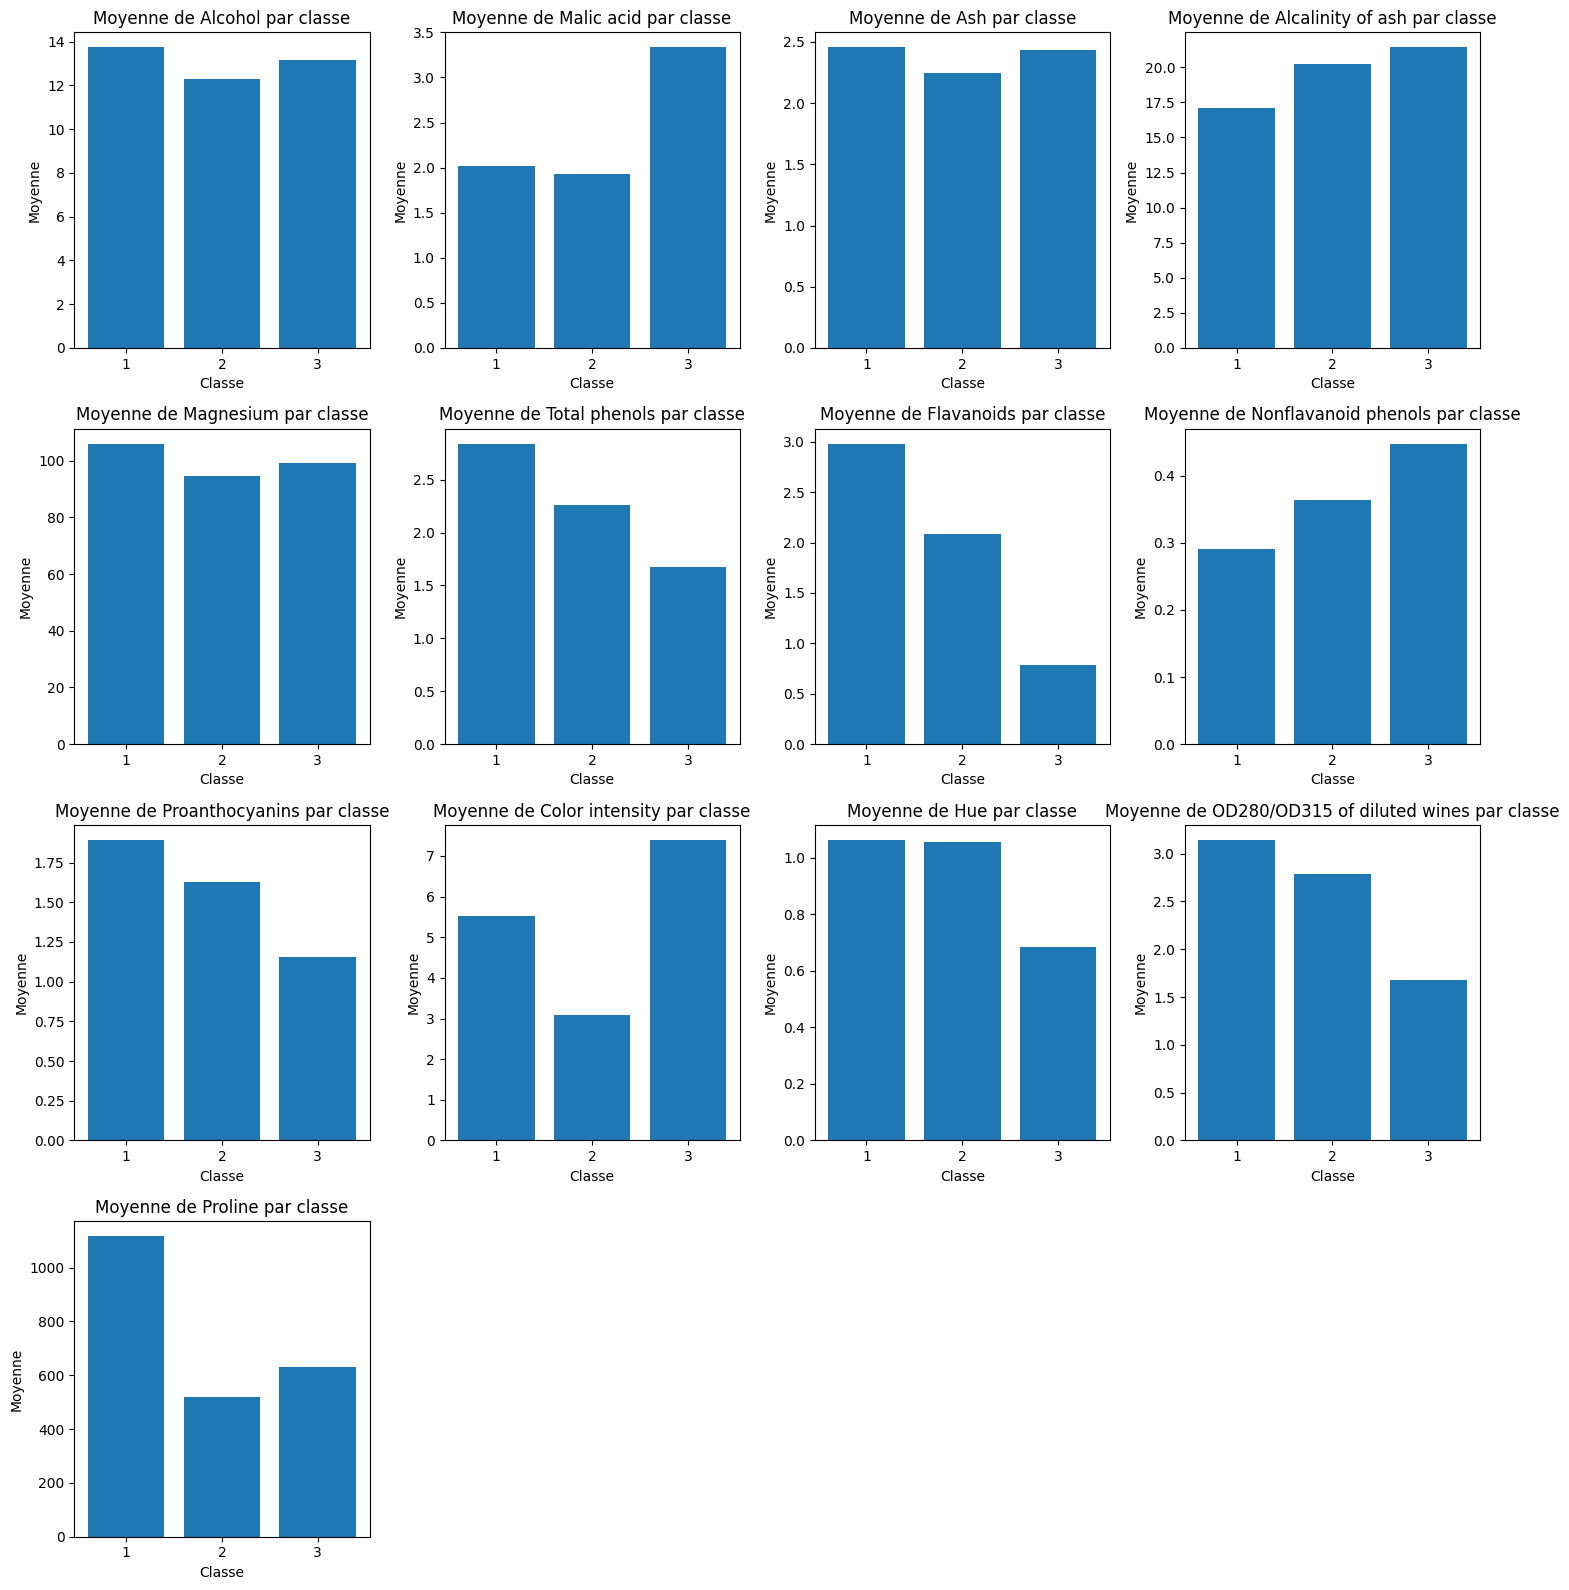

In [60]:
variables = data.columns[1:]

n_vars = len(variables)

n_cols = 4
n_rows = -(-n_vars // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, var in enumerate(variables):
    grouped = data[['Class', var]].groupby('Class').mean().reset_index()
    axes[i].bar(grouped['Class'], grouped[var])
    axes[i].set_title(f"Moyenne de {var} par classe")
    axes[i].set_xlabel("Classe")
    axes[i].set_ylabel("Moyenne")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

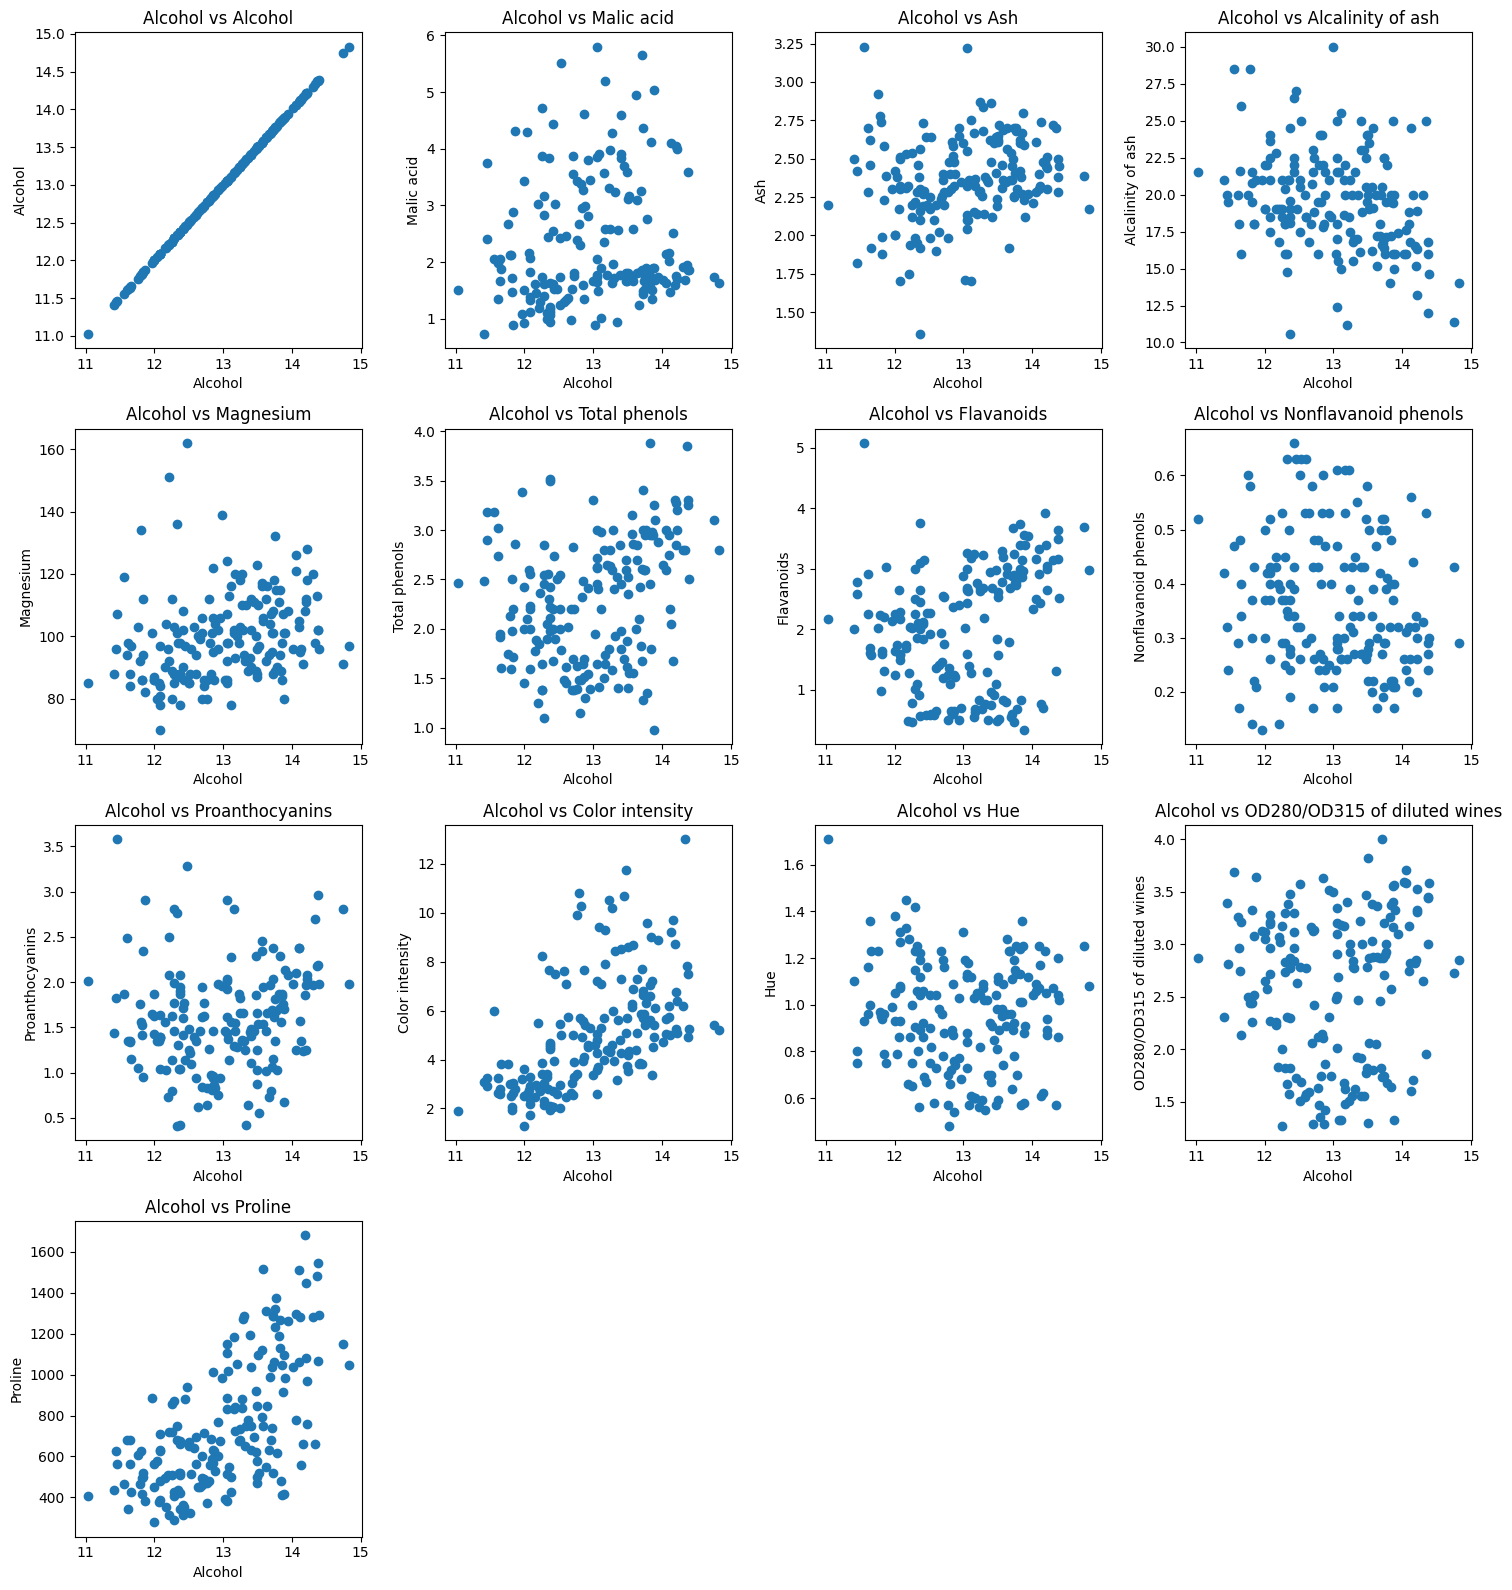

In [61]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, var in enumerate(variables):
    axes[i].scatter(data['Alcohol'], data[var])
    axes[i].set_title(f"Alcohol vs {var}")
    axes[i].set_xlabel("Alcohol")
    axes[i].set_ylabel(var)

# supprimer axes vides
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


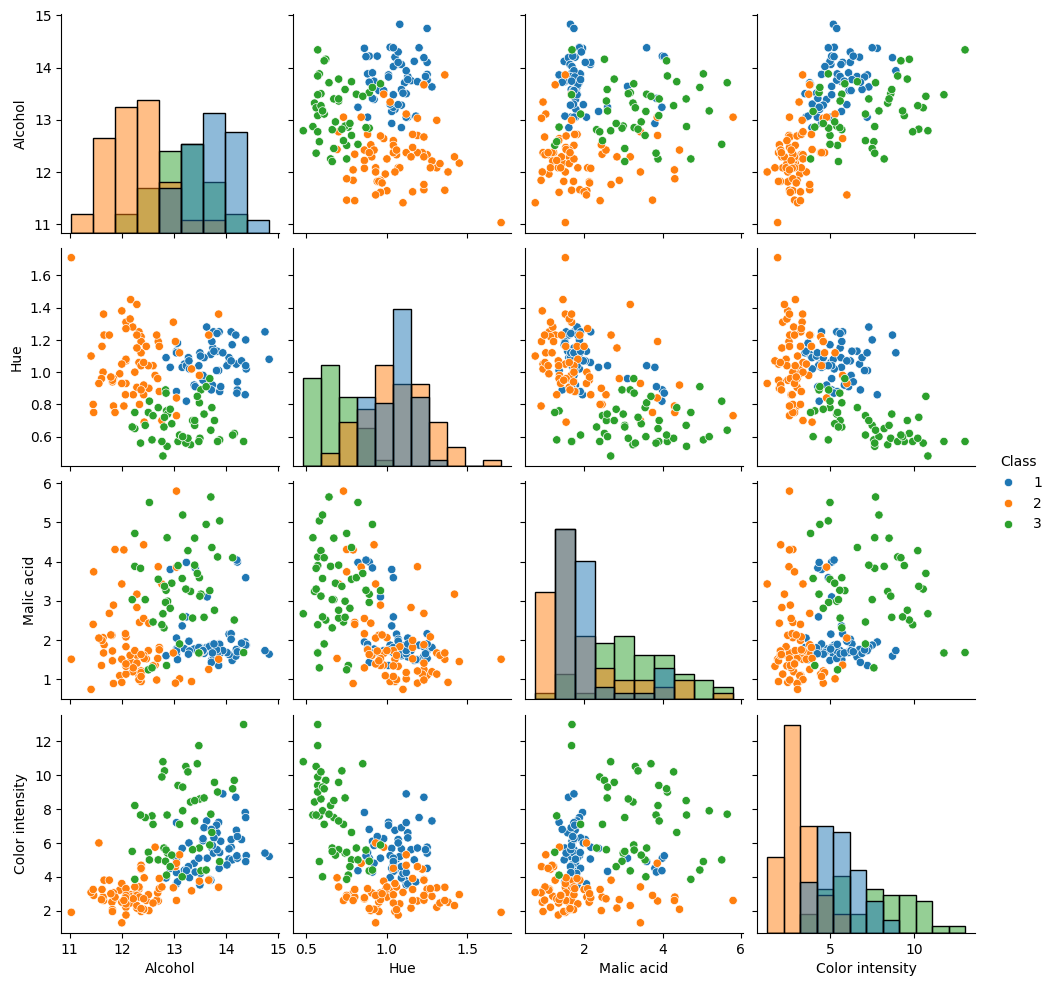

In [59]:
import seaborn as sns

sns.pairplot(
    data=data[["Class", "Alcohol", "Hue", "Malic acid", "Color intensity"]],
    hue="Class",
    diag_kind="hist"  #ou kde pour avoir plutot des courbes
)
plt.show()


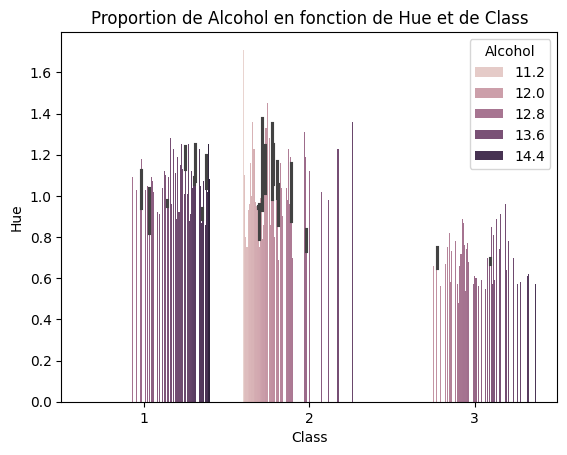

In [54]:
# Creating a grouped bar chart
sns.barplot(data=data, x='Class', y='Hue', hue='Alcohol')
plt.title('Proportion de Alcohol en fonction de Hue et de Class')
plt.show()

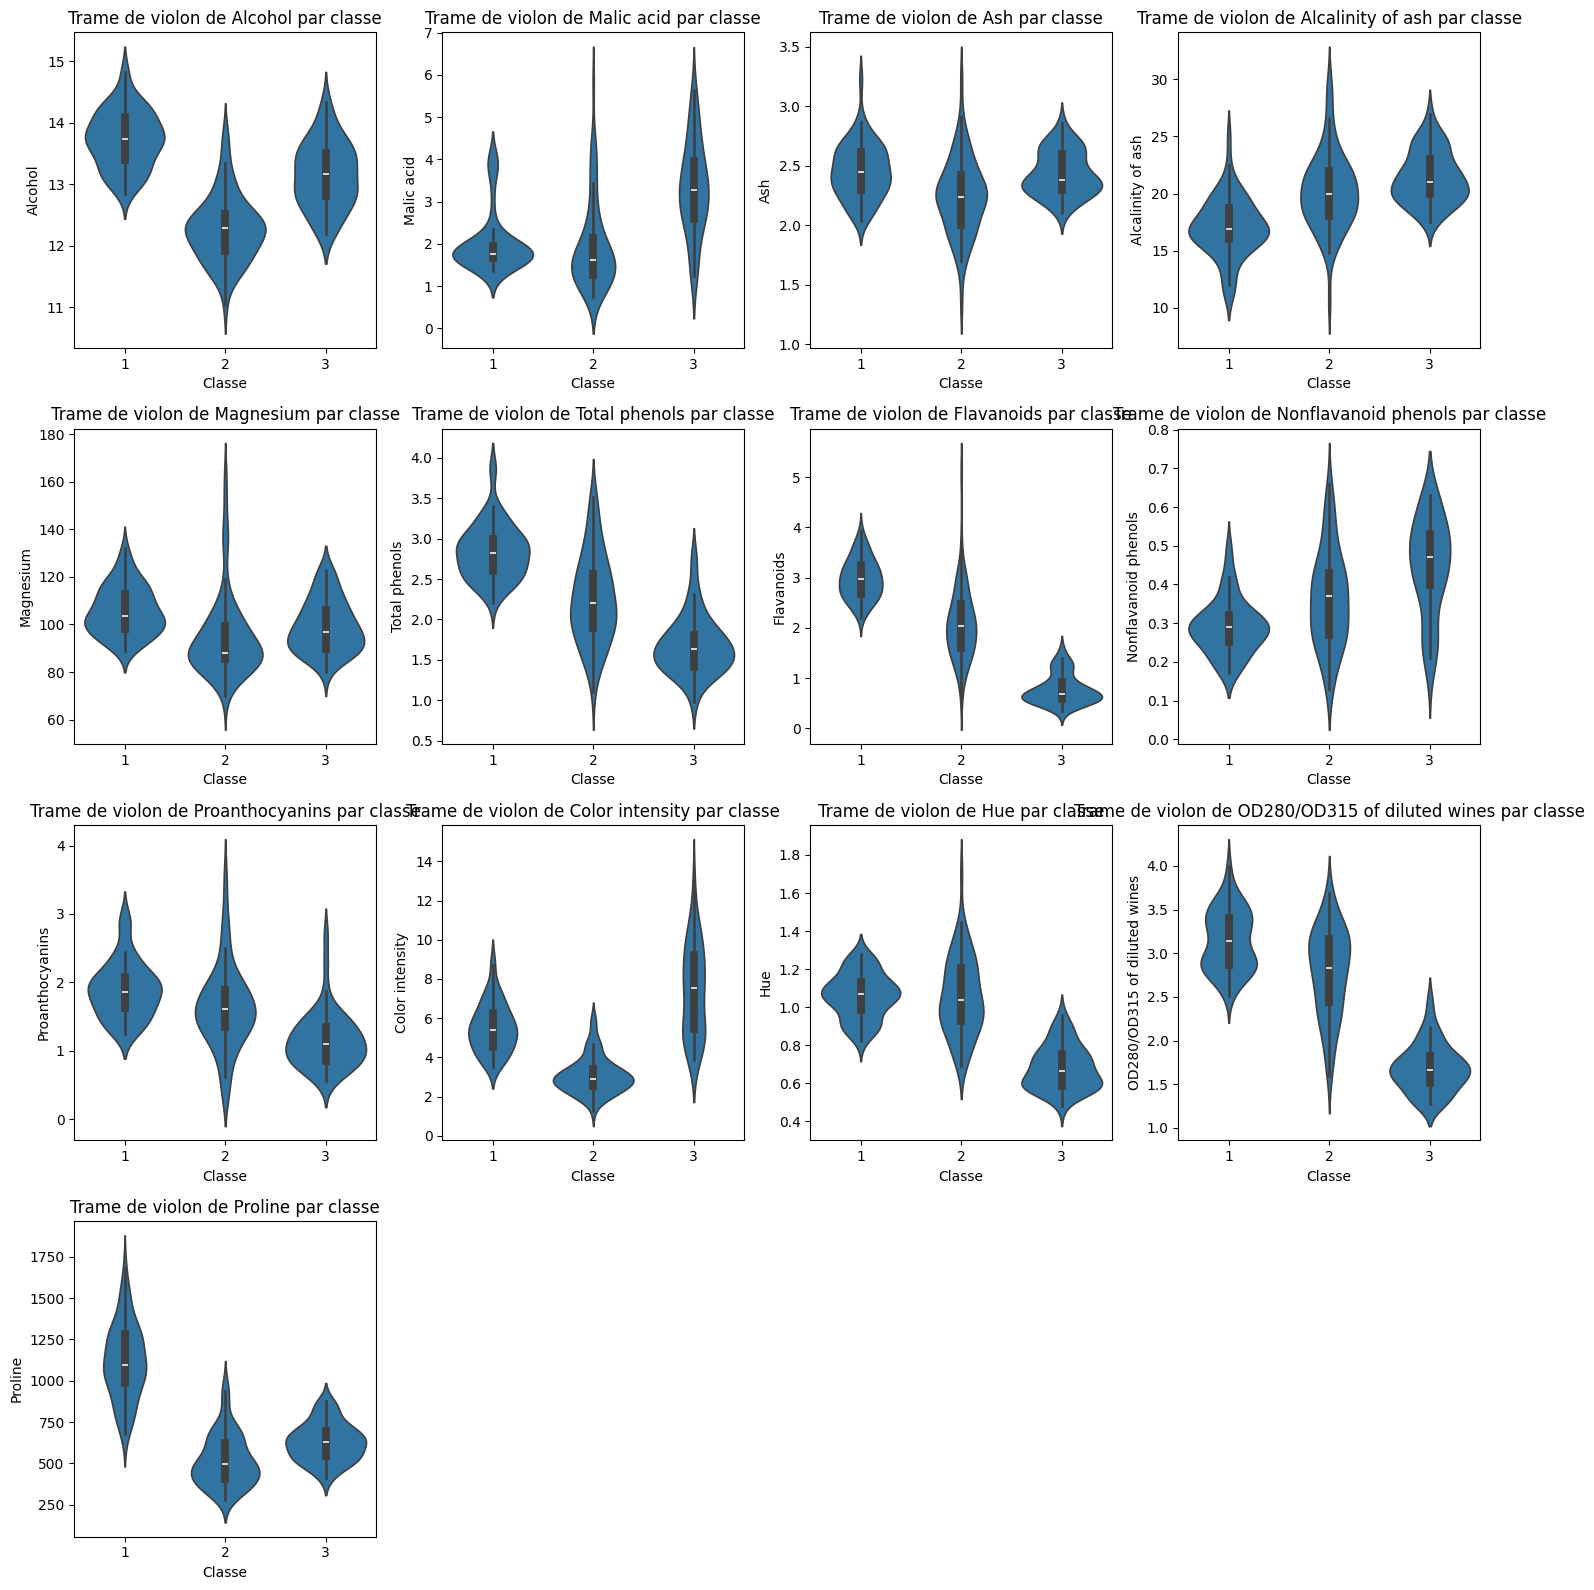

In [62]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

# Boucle sur les variables
for i, var in enumerate(variables):
    sns.violinplot(data=data, x='Class', y=var, ax=axes[i])
    axes[i].set_title(f"Trame de violon de {var} par classe")
    axes[i].set_xlabel("Classe")
    axes[i].set_ylabel(var)

# Supprimer les cases vides si nécessaire
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## techniques de discrétisation de la variable quantitative Alcohol

### 1. Equal Interval Width (largeurs égales)

On divise l’intervalle des valeurs en tranches de largeur identique.

In [63]:
var = "Alcohol"
X = data[[var]].values

k = 4  

# --- Equal Interval Width ---
data["EIW"] = pd.cut(data[var], bins=k, labels=[f"C{i+1}" for i in range(k)])

### 2. Equal Frequency (effectifs égaux)

Chaque intervalle contient (environ) le même nombre d’observations.

In [64]:
data["EF"] = pd.qcut(data[var], q=k, labels=[f"C{i+1}" for i in range(k)])


### 3. Entropy-based

On utilise un arbre de décision pour trouver les seuils qui minimisent l’entropie (maximiser la pureté par rapport à une cible).
La variable cible est la variable "Class".

In [66]:
from sklearn.tree import DecisionTreeClassifier

X = data[[var]]
y = data["Class"]

tree = DecisionTreeClassifier(max_leaf_nodes=k)
tree.fit(X, y)

# seuils trouvés
thresholds = sorted(tree.tree_.threshold[tree.tree_.threshold > -2])

# on applique les seuils
bins = [-np.inf] + thresholds + [np.inf]
data["Entropy"] = pd.cut(data[var], bins=bins, labels=[f"C{i+1}" for i in range(len(bins)-1)])


### 4. Clustering (KMeans)

On regroupe les valeurs par clusters, puis on attribue les classes.

In [67]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
data["Cluster"] = kmeans.fit_predict(X)
data["Cluster"] = data["Cluster"].map(lambda c: f"C{c+1}")

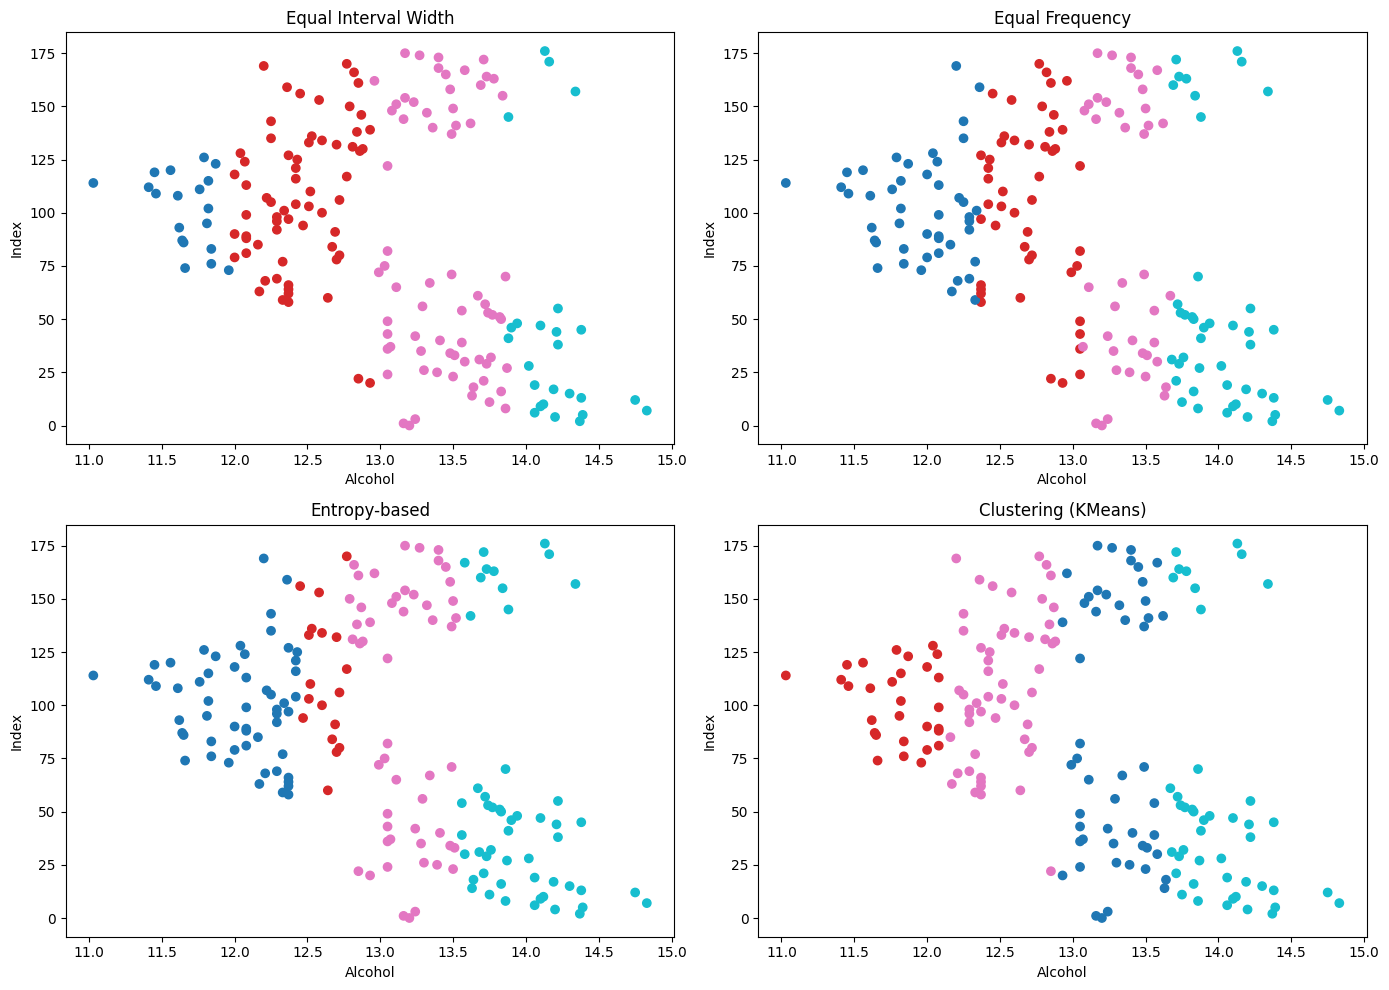

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

methods = ["EIW", "EF", "Entropy", "Cluster"]
titles = [
    "Equal Interval Width",
    "Equal Frequency",
    "Entropy-based",
    "Clustering (KMeans)"
]

for ax, method, title in zip(axes.flatten(), methods, titles):
    ax.scatter(data[var], data.index, c=data[method].astype('category').cat.codes, cmap="tab10")
    ax.set_title(title)
    ax.set_xlabel(var)
    ax.set_ylabel("Index")

plt.tight_layout()
plt.show()
